# Electric car charging points in Germany

## Data import and basic checks

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set(style = 'dark')
sns.set_context(rc = {'font.size': 12, 'font.family'  : 'sans-serif','font.sans-serif':'Verdana'})

In [2]:
data = pd.read_excel('data/Ladesaeulenkarte_Datenbankauszug30.xlsx', skiprows=5, decimal = ',')

In [3]:
data.columns = data.columns.str.replace(' ', '')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Betreiber              13006 non-null  object        
 1   Adresse                13006 non-null  object        
 2   PostleitzahlOrt        13006 non-null  object        
 3   Bundesland             13006 non-null  object        
 4   Längengrad[DG]         13006 non-null  object        
 5   Breitengrad[DG]        13006 non-null  object        
 6   Inbetriebnahmedatum    13006 non-null  datetime64[ns]
 7   Anschlussleistung[kW]  13006 non-null  float64       
 8   ArtderLadeeinrichtung  13006 non-null  object        
 9   AnzahlLadepunkte       13006 non-null  int64         
 10  Steckertypen1          13006 non-null  object        
 11  P1[kW]                 13006 non-null  float64       
 12  PublicKey1             448 non-null    object        
 13  S

In [5]:
data.nunique().sort_values()

ArtderLadeeinrichtung        2
AnzahlLadepunkte             4
PublicKey4                   8
PublicKey3                   9
Steckertypen4               11
Steckertypen3               12
Bundesland                  16
P4[kW]                      16
Steckertypen2               24
P3[kW]                      25
Steckertypen1               31
P2[kW]                      39
P1[kW]                      47
Anschlussleistung[kW]      108
PublicKey2                 384
PublicKey1                 447
Betreiber                 1408
Inbetriebnahmedatum       1912
PostleitzahlOrt           4938
Adresse                  10585
Breitengrad[DG]          11460
Längengrad[DG]           11470
dtype: int64

### Summary
* There are total 13006 entries in the dataset.
* The dataset contains information of charging stations that started operation from 2008-07-19 to 2020-03-02.
* For every charging station this dataset includes information on:
    + The charging station operator
    + Address of the station
    + The postal code of the location
    + The german federal state where the station is located
    + The latitute and longitue of the location
    + The date of start of operation
    + The power of the electrical connection to the station
    + Type of charging used in the station (normal or fast)
    + Number of charging points in the station
    + Connection type and rated power of each charging point

## Aim of the analysis

In this analysis, the following questions will be answered:

1. How are the charging stations distributed geographically and temporally distributed?
1. How are the electrical power of the stations geographically and temporally distributed?
1. Is there a clearn urban/rural divide in the distribution of the charging stations? 
1. Which city or district has the most number of charging stations per 1000 residents?
1. Which states have the fastest rate of growth in the past 3 years (2017, 2018, 2019)?

## Analysis 1

In [6]:
bundesland_summary = pd.pivot_table(data = data, index = 'Bundesland', values = 'AnzahlLadepunkte', aggfunc = ['count', 'sum'])
bundesland_summary.reset_index(inplace=True)
bundesland_summary.columns = ['Bundesland', 'counts', 'sum']
bundesland_summary['mean'] = bundesland_summary['sum'] / bundesland_summary['counts']
bundesland_summary['share'] = (bundesland_summary['counts'] / bundesland_summary['counts'].sum()) * 100

In [7]:
bundesland_summary.sort_values(by='counts', ascending=False, inplace=True)

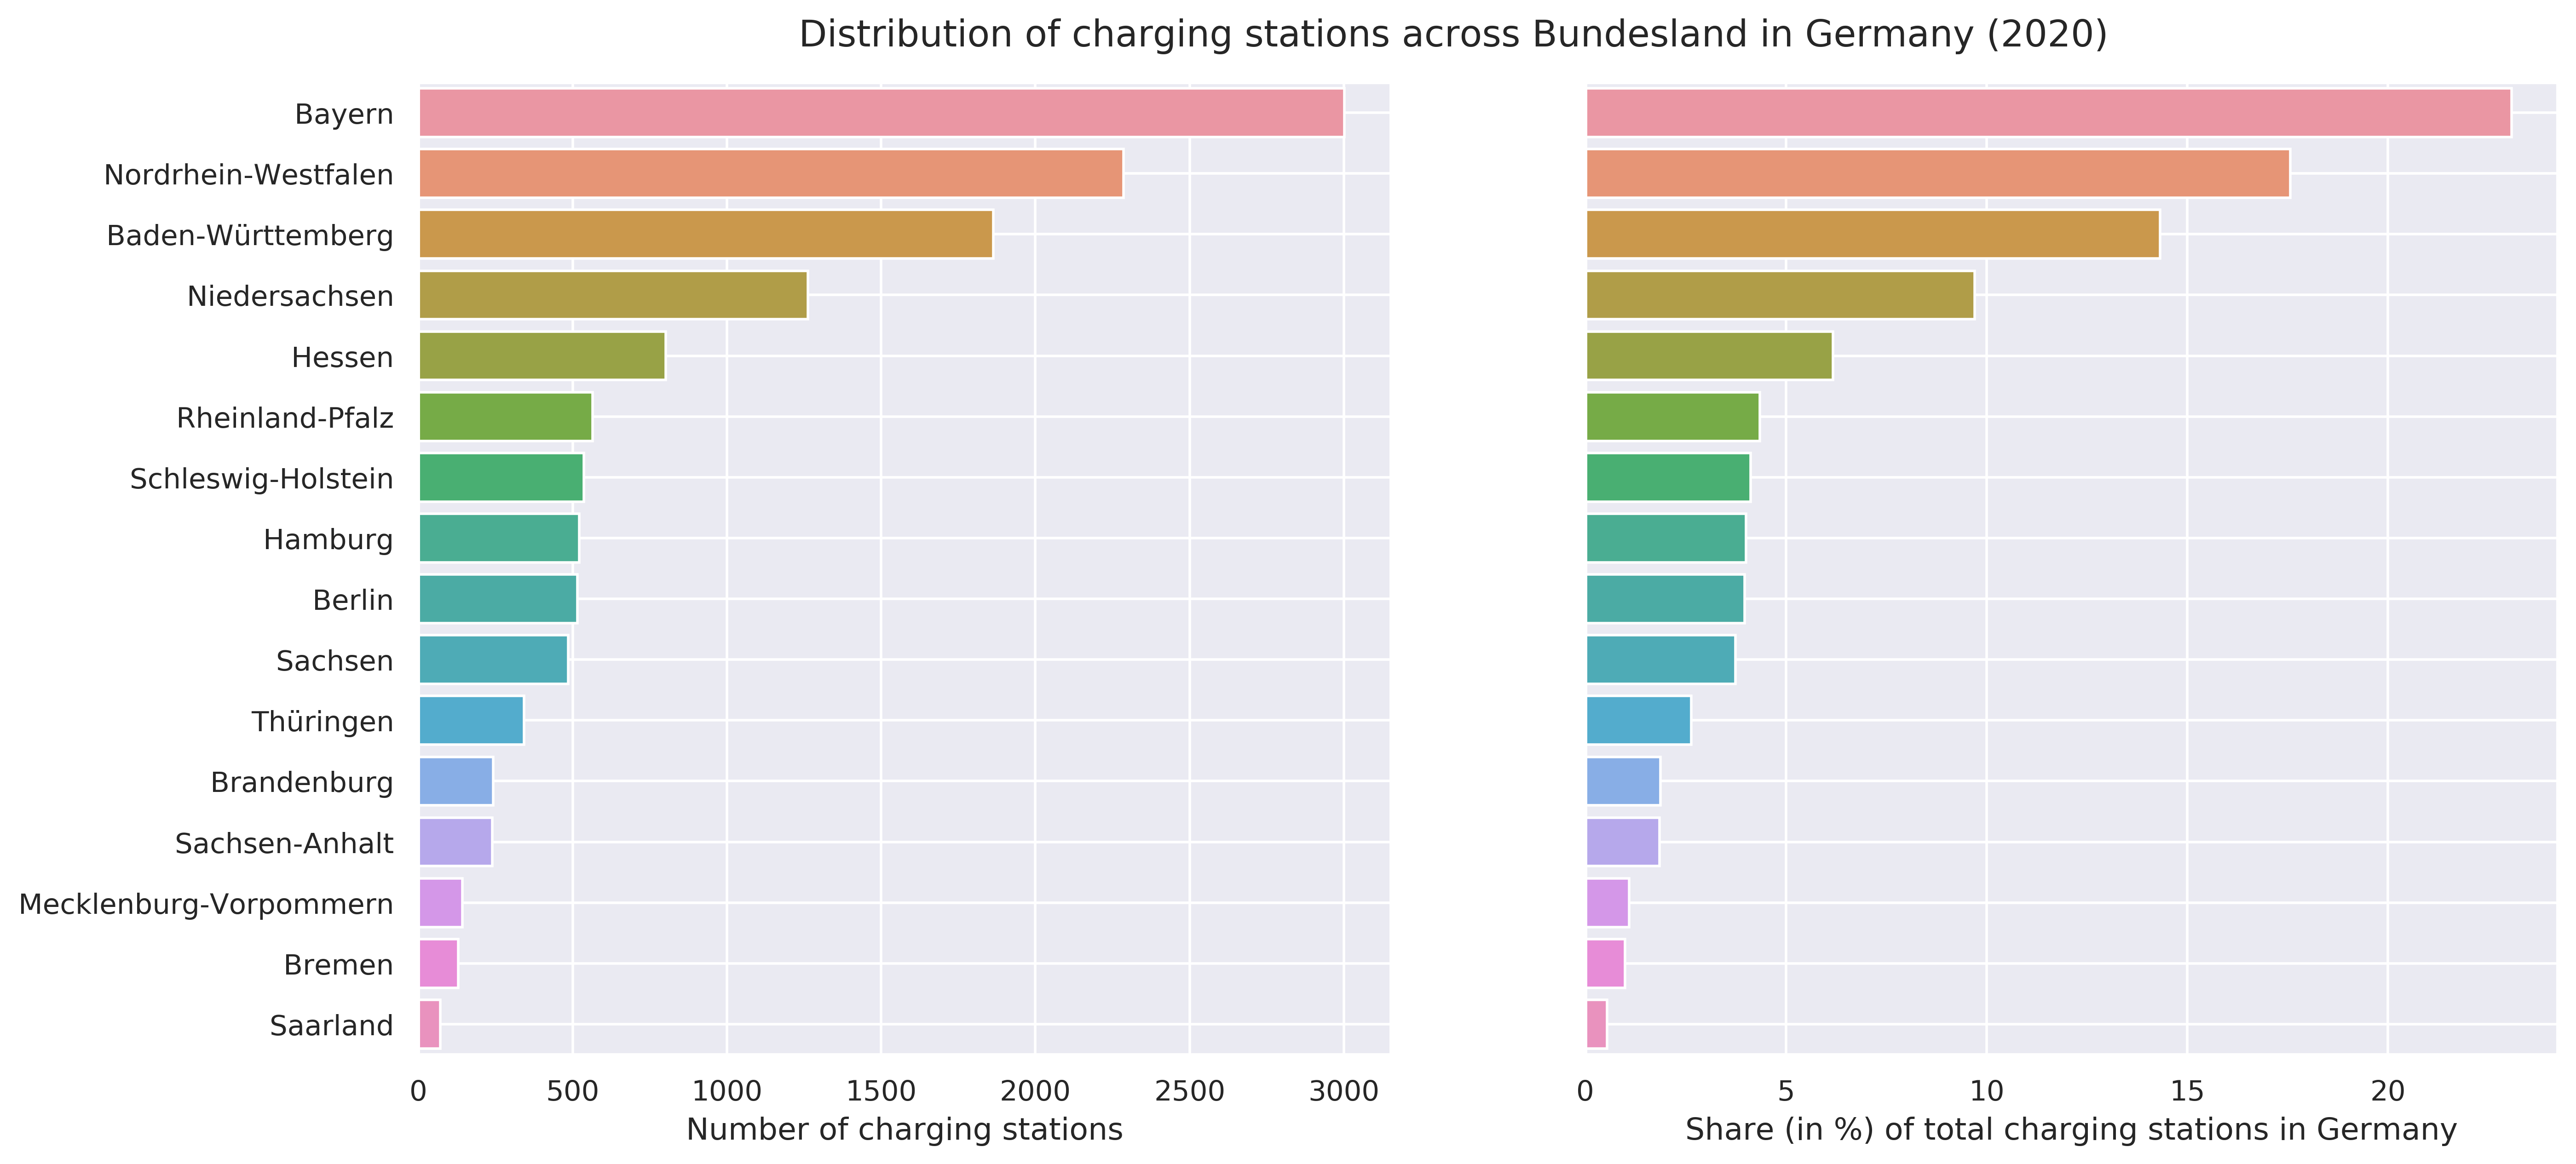

In [8]:
fig, ax = plt.subplots(1,2, figsize = (15,7), sharey=True, dpi=400)
sns.barplot(data = bundesland_summary, x = 'counts', y = 'Bundesland',ax =ax[0])
ax[0].set_xlabel('Number of charging stations')
ax[0].set_ylabel('')
ax[0].grid()
sns.barplot(data = bundesland_summary, x = 'share', y = 'Bundesland', ax =ax[1])
ax[1].set_xlabel('Share (in %) of total charging stations in Germany')
ax[1].set_ylabel('')
ax[1].grid()
plt.suptitle('Distribution of charging stations across Bundesland in Germany (2020)', y=0.93, weight=500);

In [55]:
date_summary = pd.pivot_table(data = data, index = 'Inbetriebnahmedatum', columns = 'Bundesland', values = 'AnzahlLadepunkte', aggfunc = 'count')

In [56]:
date_summary_month = date_summary.resample('M').sum()

In [57]:
bundeslands = data['Bundesland'].unique()

In [59]:
for bundesland in bundeslands:
    date_summary_month[bundesland] = date_summary_month[bundesland].cumsum() 

date_summary_month.ffill(axis=0, inplace=True)
date_summary_month.fillna(0, inplace=True)
date_summary_month['sum'] = date_summary_month[bundeslands].sum(axis=1)
date_summary_month['pct_change'] = date_summary_month['sum'].pct_change() * 100

In [60]:
date_summary_month

Bundesland,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen,sum,pct_change
Inbetriebnahmedatum,,,,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2008-08-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
2008-09-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
2008-10-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
2008-11-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,1788.0,2826.0,510.0,225.0,129.0,521.0,773.0,134.0,1203.0,2178.0,554.0,61.0,415.0,220.0,514.0,331.0,12382.0,3.166139
2019-12-31,1832.0,2890.0,513.0,231.0,129.0,521.0,785.0,140.0,1233.0,2249.0,559.0,66.0,465.0,235.0,532.0,336.0,12716.0,2.697464
2020-01-31,1854.0,2967.0,516.0,236.0,129.0,521.0,795.0,141.0,1252.0,2268.0,564.0,67.0,475.0,238.0,533.0,339.0,12895.0,1.407675


In [61]:
bland_1 = ['Bayern', 'Nordrhein-Westfalen', 'Baden-Württemberg',
       'Niedersachsen']
bland_2 = ['Hessen', 'Rheinland-Pfalz', 'Schleswig-Holstein',
       'Hamburg', 'Berlin']
bland_3 = ['Sachsen', 'Thüringen', 'Brandenburg',
       'Sachsen-Anhalt', 'Mecklenburg-Vorpommern', 'Bremen', 'Saarland']

In [69]:
date_summary_month.resample('Y').sum()['sum'].pct_change(periods=2)*100

Inbetriebnahmedatum
2008-12-31             NaN
2009-12-31             NaN
2010-12-31    23200.000000
2011-12-31      618.997912
2012-12-31      308.226037
2013-12-31      115.040650
2014-12-31       83.020852
2015-12-31      109.478801
2016-12-31      154.360938
2017-12-31      200.747712
2018-12-31      198.031466
2019-12-31      178.329547
2020-12-31      -50.873316
Freq: A-DEC, Name: sum, dtype: float64

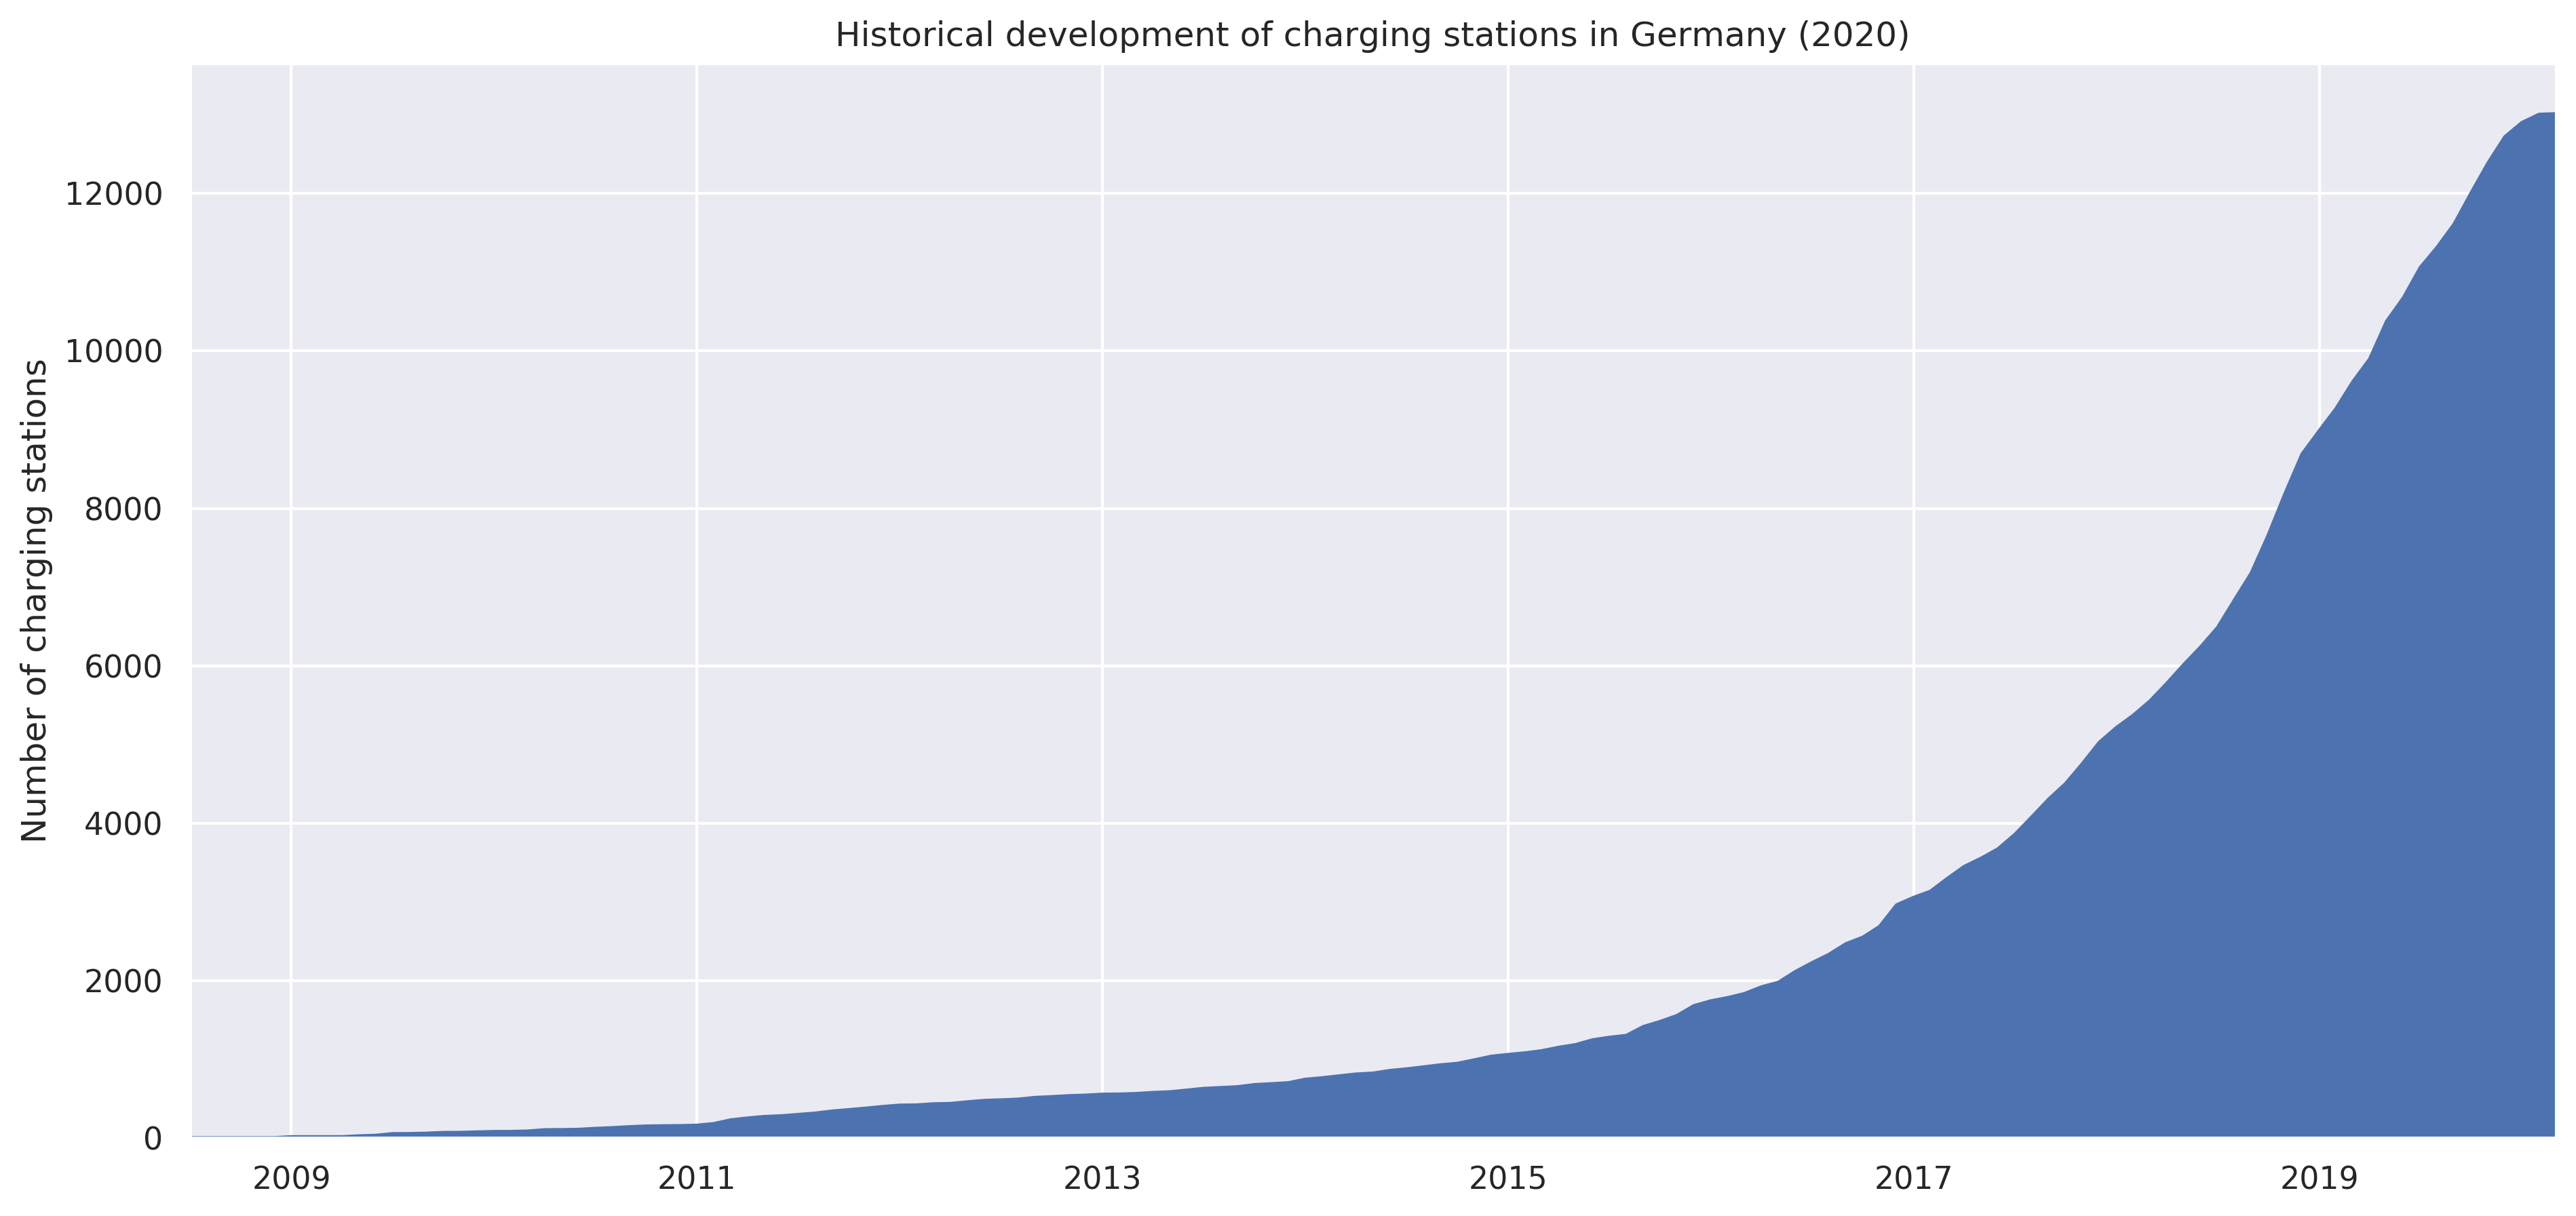

In [63]:
fig, ax = plt.subplots(figsize = (15,7), dpi=300)
date_summary_month['sum'].plot.area(ax =ax)
ax.grid()
ax.set_xlabel('')
ax.set_ylabel('Number of charging stations')
plt.title('Historical development of charging stations in Germany (2020)', weight='500');

> From the graph it is clear that starting from 2015, there has been expoenential growth in the number of charging stations. In the next couple of graphs, data starting from 2015 has been plotted to give better idea of the recent developments.

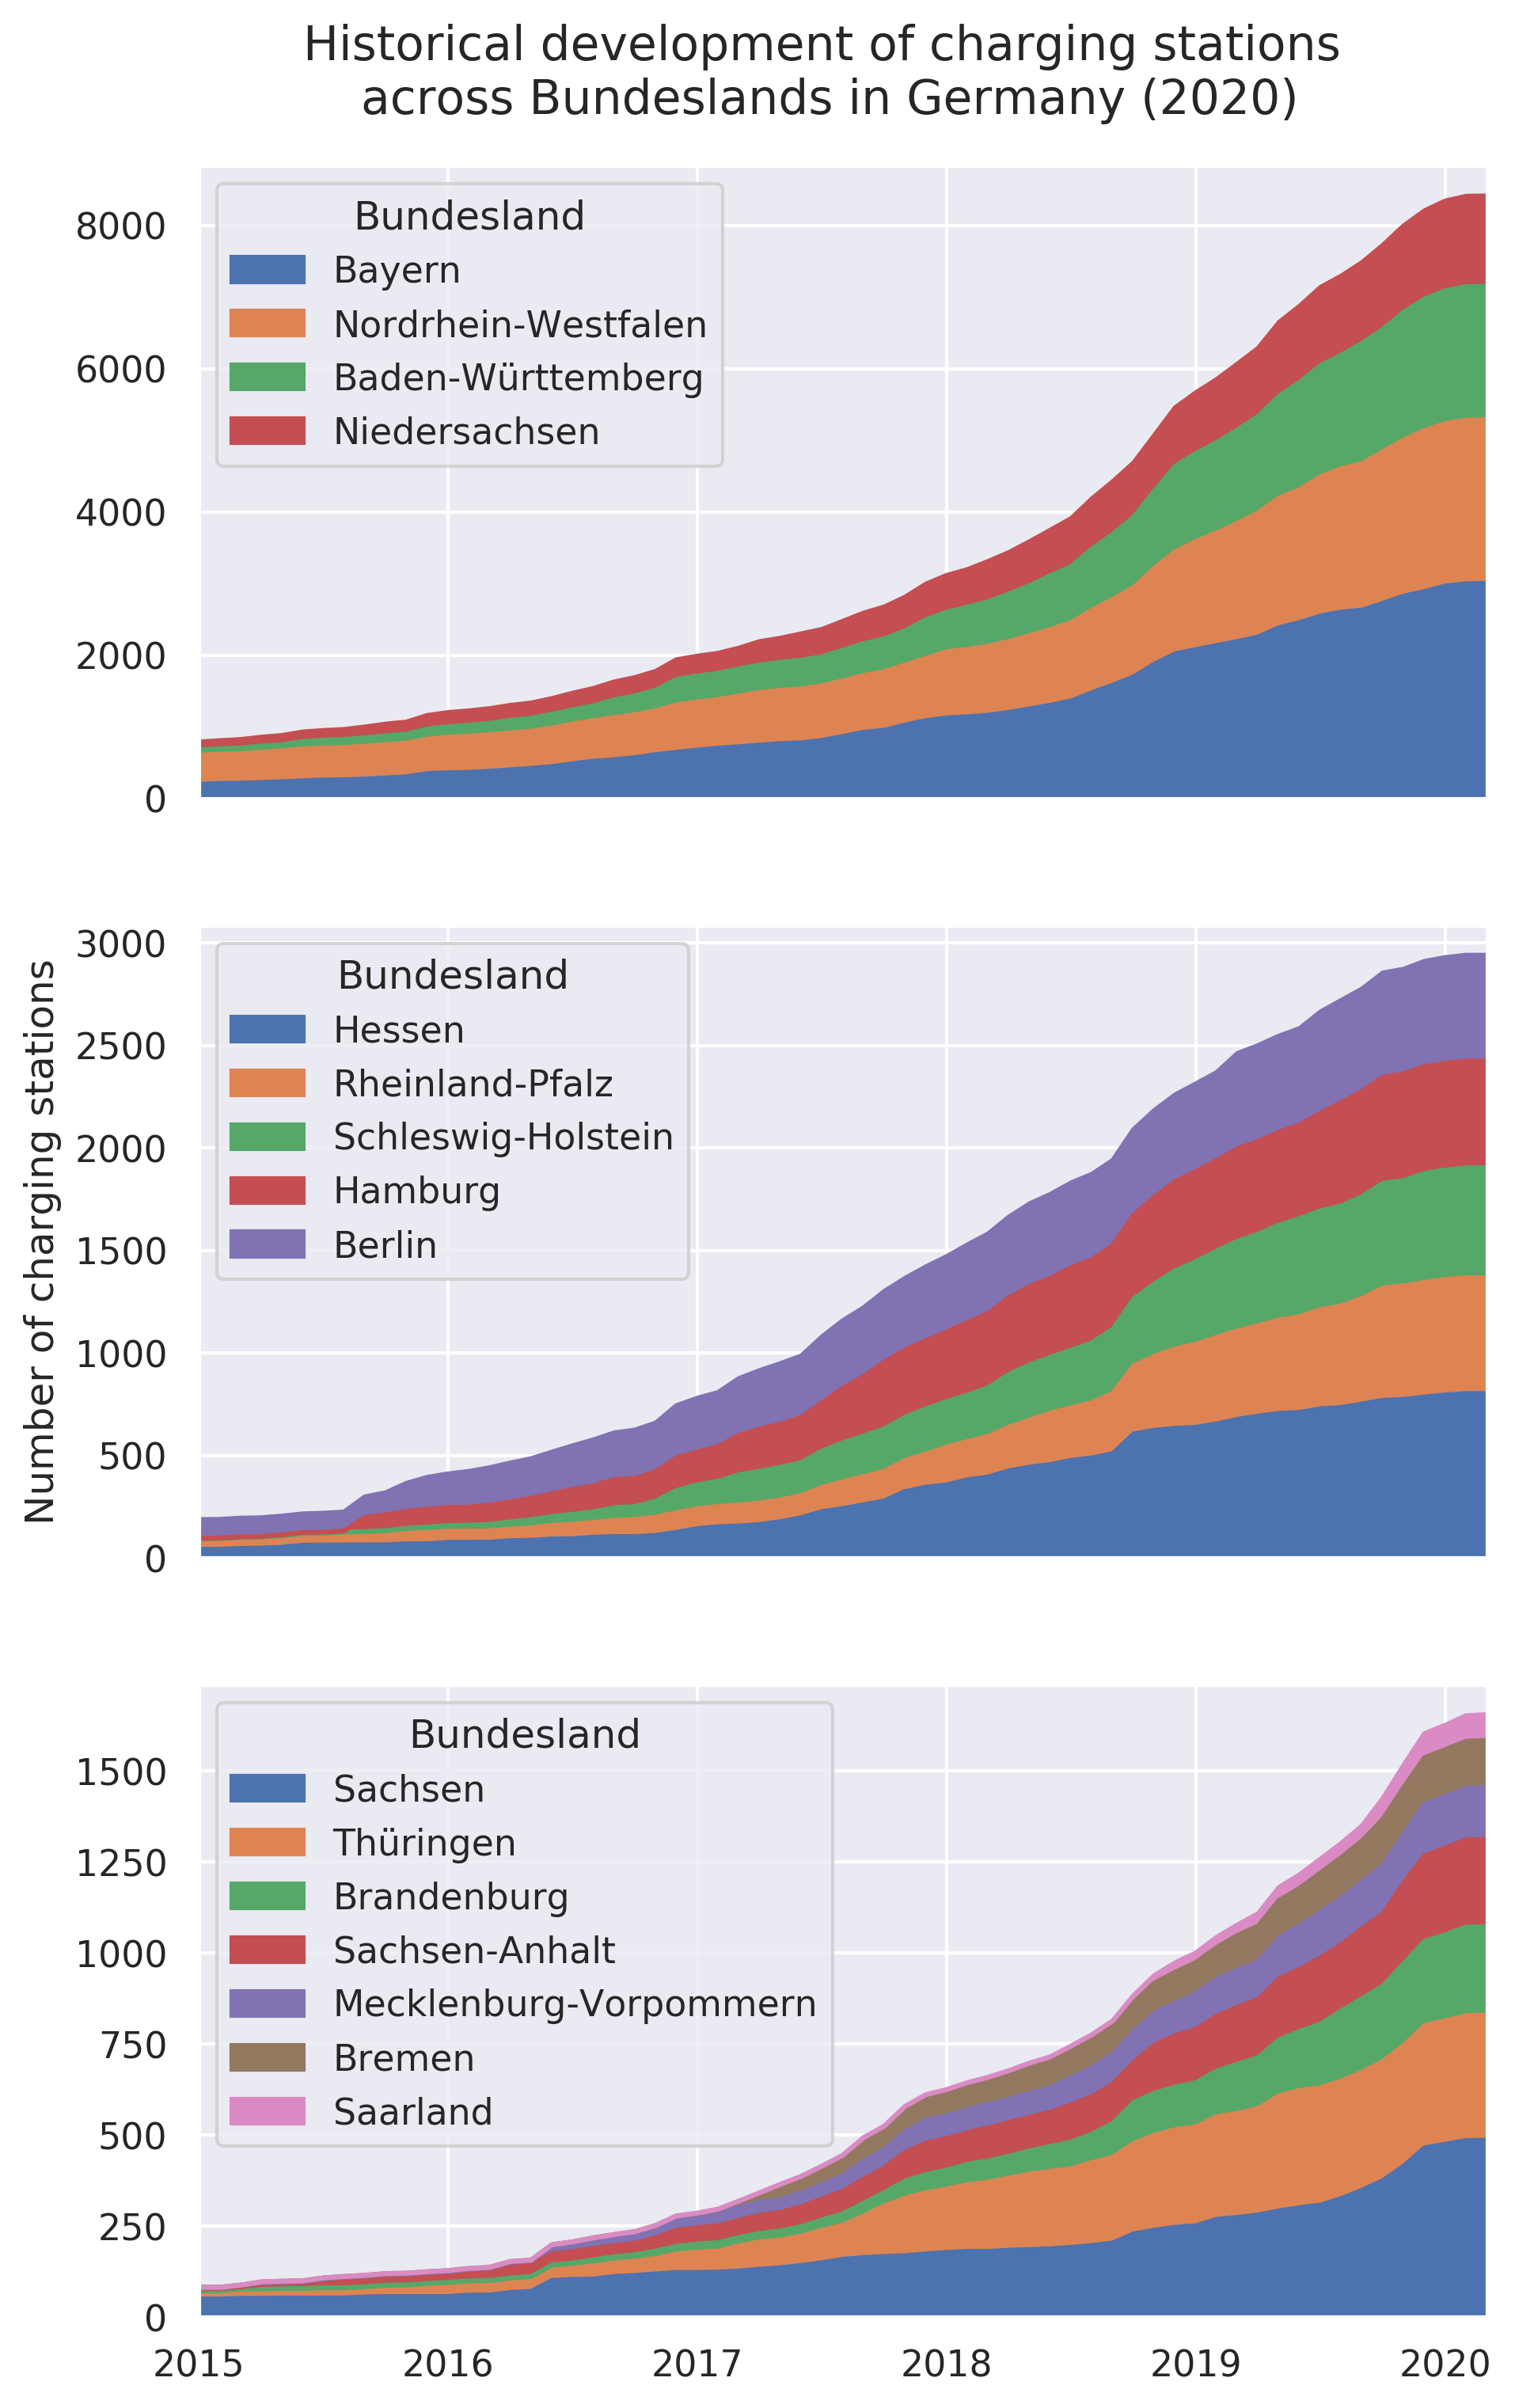

In [77]:
fig, ax = plt.subplots(3,1, figsize = (7,12), sharex=True, dpi=300)
date_summary_month['2015-01-01':][bland_1].plot.area(ax=ax[0])
date_summary_month['2015-01-01':][bland_2].plot.area(ax=ax[1])
date_summary_month['2015-01-01':][bland_3].plot.area(ax=ax[2])
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.xlabel('')
ax[1].set_ylabel('Number of charging stations')
# plt.tight_layout()
fig.suptitle('Historical development of charging stations\n across Bundeslands in Germany (2020)', y=0.93, weight='500');

In [79]:
cap_summary = pd.pivot_table(data = data, index = 'Inbetriebnahmedatum', columns = 'Bundesland', values = 'Anschlussleistung[kW]', aggfunc = 'sum')

In [80]:
cap_summary_month  = cap_summary.resample('M').sum()

In [81]:
for bundesland in bundeslands:
    cap_summary_month[bundesland] = cap_summary_month[bundesland].cumsum()
cap_summary_month[bundeslands] = cap_summary_month[bundeslands]/1000

cap_summary_month['sum'] = cap_summary_month[bundeslands].sum(axis=1)
cap_summary_month['pct_change'] = cap_summary_month['sum'].pct_change() * 100

In [82]:
cap_summary_month

Bundesland,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen,sum,pct_change
Inbetriebnahmedatum,,,,,,,,,,,,,,,,,,
2008-07-31,0.0440,0.0000,0.000,0.0000,0.000,0.000,0.00000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.04400,NaN
2008-08-31,0.0440,0.0000,0.000,0.0000,0.000,0.000,0.00000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.04400,0.000000
2008-09-30,0.0440,0.0000,0.000,0.0000,0.000,0.000,0.00000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.04400,0.000000
2008-10-31,0.0440,0.0000,0.000,0.0000,0.000,0.000,0.00000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.04400,0.000000
2008-11-30,0.0440,0.0000,0.000,0.0000,0.000,0.000,0.00000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.04400,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,91.9756,137.8506,14.844,11.5562,6.703,23.731,37.18393,7.0537,70.3071,104.68974,33.4578,3.493,25.4856,13.4047,28.2571,21.131,631.12407,2.535592
2019-12-31,94.1586,142.4536,15.015,11.7762,6.703,23.731,37.54593,7.8477,71.9841,107.37174,33.7408,3.745,30.0956,13.9547,29.0271,21.340,650.49007,3.068493
2020-01-31,94.8946,145.8646,15.081,11.9192,6.703,23.731,37.85393,8.0077,73.0701,107.98774,33.9788,3.895,30.8096,14.1207,29.0491,21.436,658.40207,1.216314


Text(0, 0.5, 'Capacity in MW')

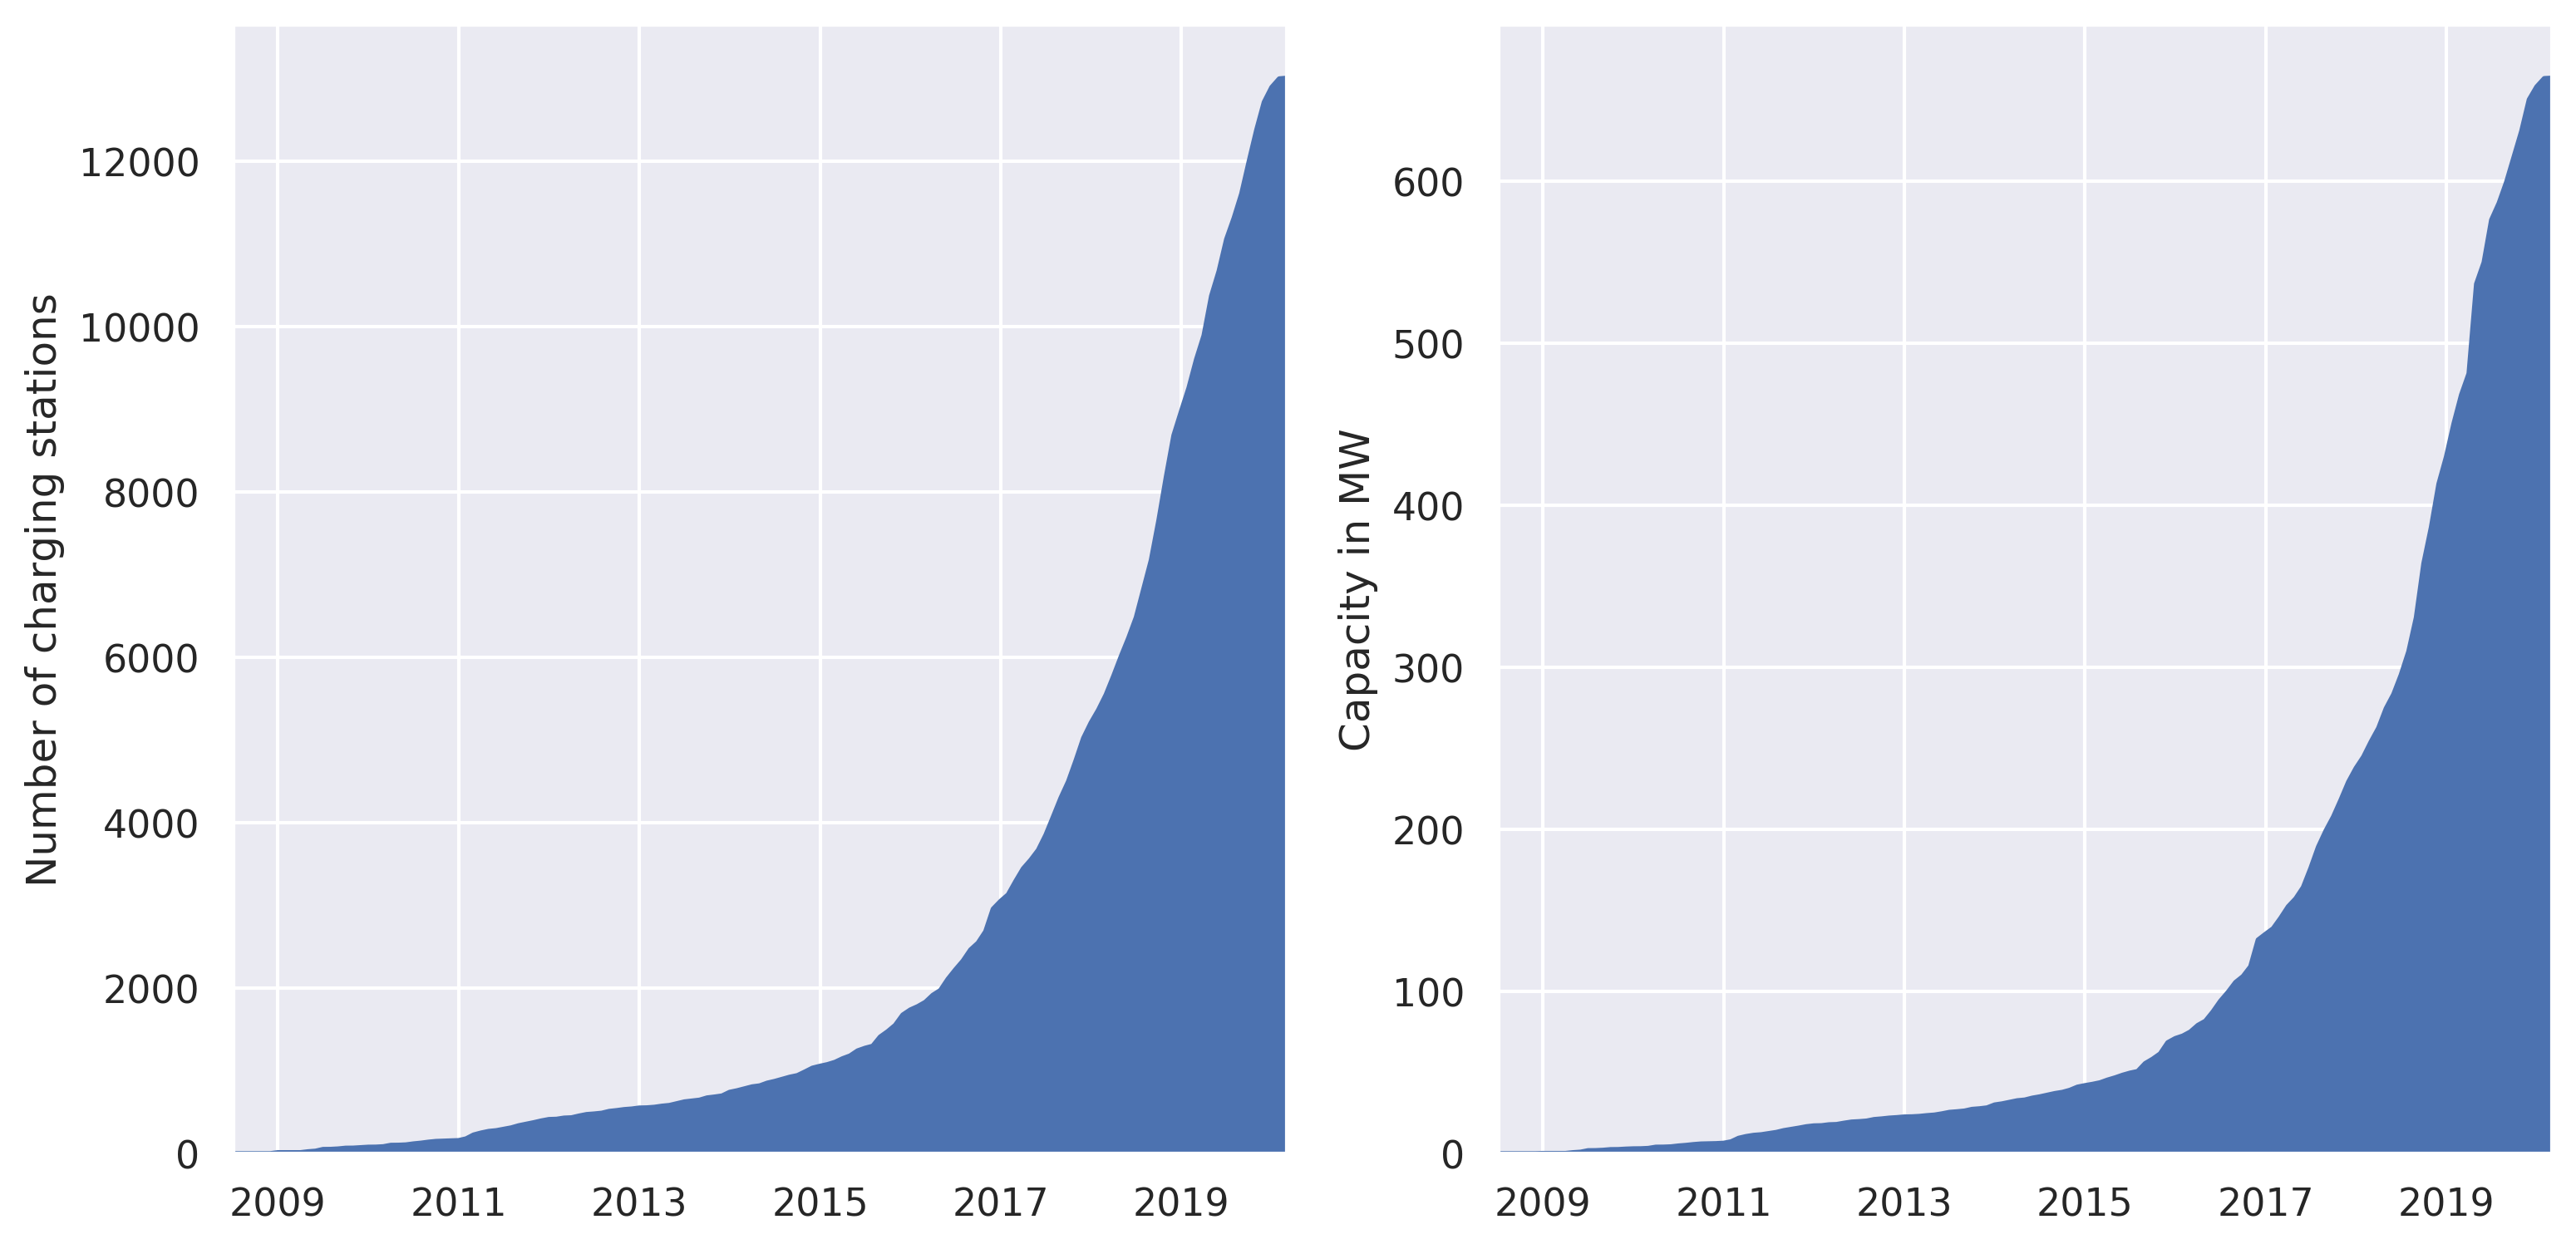

In [116]:
fig, ax = plt.subplots(1, 2, figsize = (12,6), dpi = 300)
date_summary_month['sum'].plot.area(ax =ax[0])
ax[0].grid()
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of charging stations')
# ax[0,0].set_title('Historical development of\n number of charging stations in Germany (2020)', y = 0.98, weight='500');

cap_summary_month['sum'].plot.area(ax =ax[1])
ax[1].grid()
ax[1].set_xlabel('')
ax[1].set_ylabel('Capacity in MW')
# ax[0,1].set_title('Historical development of\n total capacity (MW) of charging stations in Germany (2020)', weight='500');

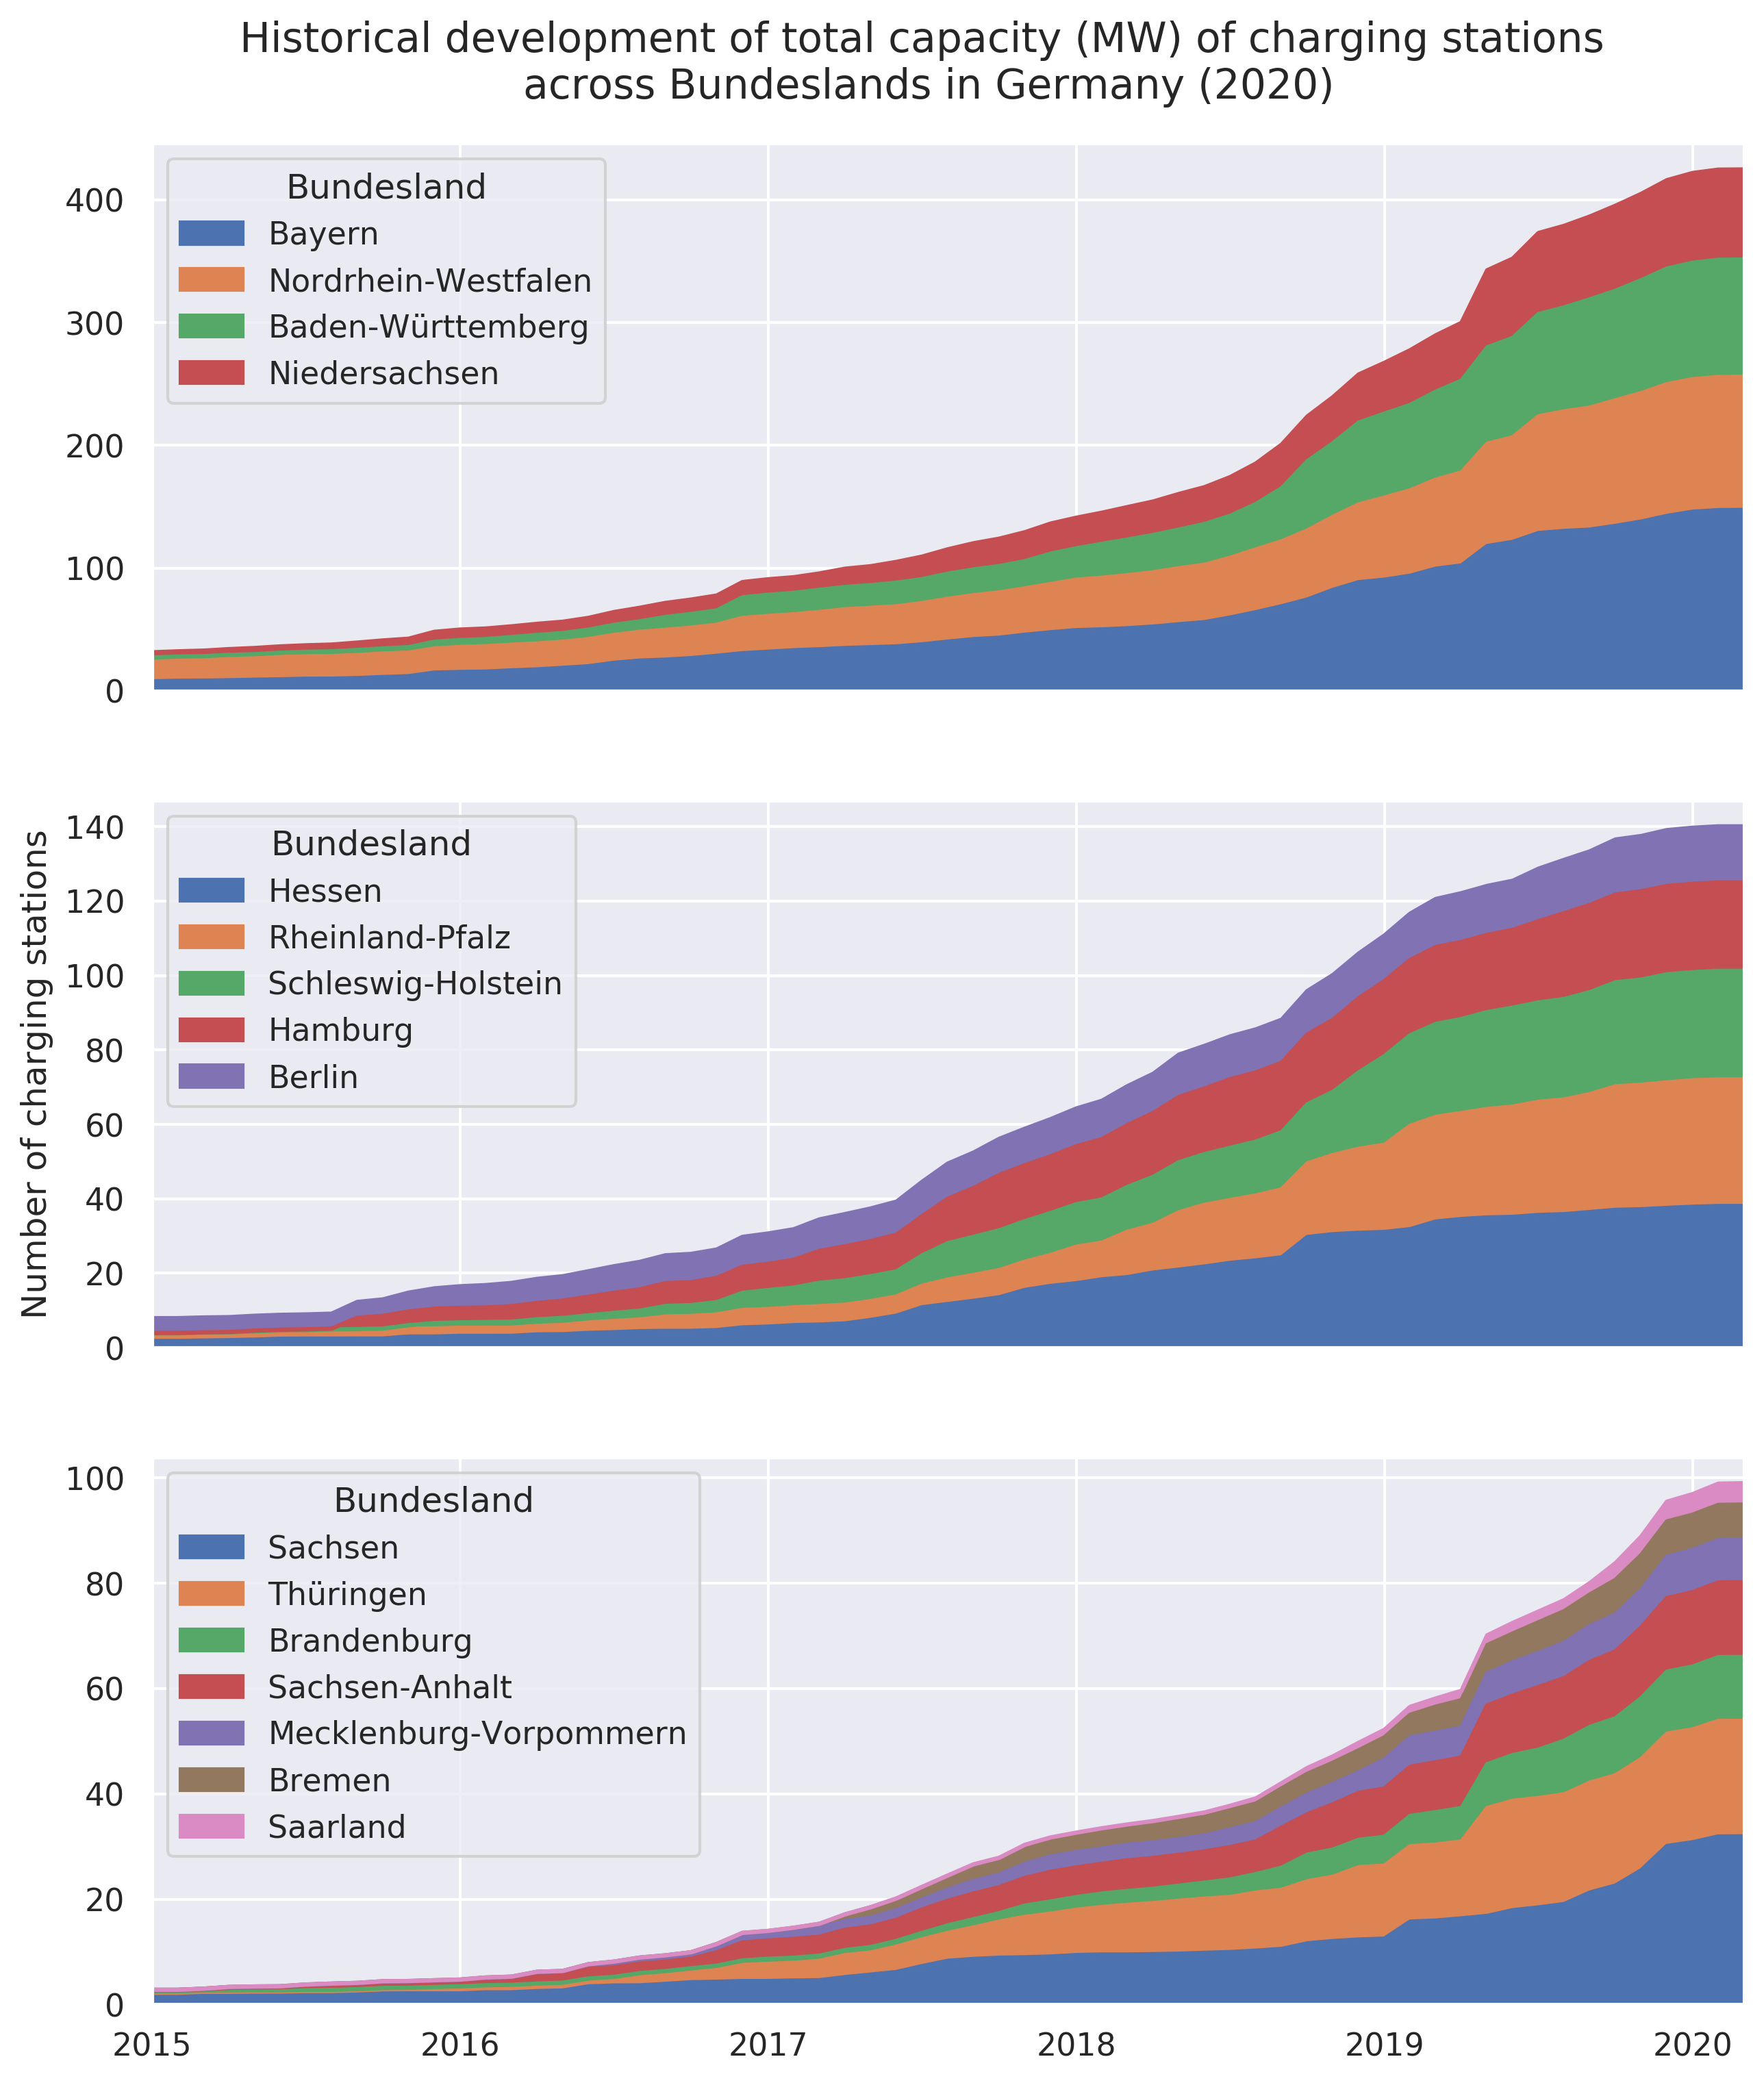

In [78]:
fig, ax = plt.subplots(3,1, figsize = (10,12), sharex=True, dpi=300)
cap_summary_month['2015-01-01':][bland_1].plot.area(ax=ax[0])
cap_summary_month['2015-01-01':][bland_2].plot.area(ax=ax[1])
cap_summary_month['2015-01-01':][bland_3].plot.area(ax=ax[2])
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.xlabel('')
ax[1].set_ylabel('Number of charging stations')
# plt.tight_layout()
fig.suptitle('Historical development of total capacity (MW) of charging stations\n across Bundeslands in Germany (2020)', y=0.93, weight='500');

In [23]:
data['Betreiber'].value_counts()[:40]

EnBW Energie Baden-Württemberg                           640
SWM Versorgungs GmbH                                     551
innogy eMobility Solutions GmbH                          536
Charge-ON GmbH                                           526
EWE Go GmbH                                              506
Stromnetz Hamburg Gmbh                                   482
Allego GmbH                                              457
E-WALD GmbH                                              318
IONITY GmbH                                              314
innogy SE                                                282
N-ERGIE Aktiengesellschaft                               230
Lidl Dienstleistung GmbH & Co. KG                        158
Lechwerke AG                                             153
ENTEGA Energie GmbH                                      131
Autobahn Tank & Rast GmbH                                129
Regensburger Energie- und Wasserversorgung AG & Co KG    115
Kaufland                

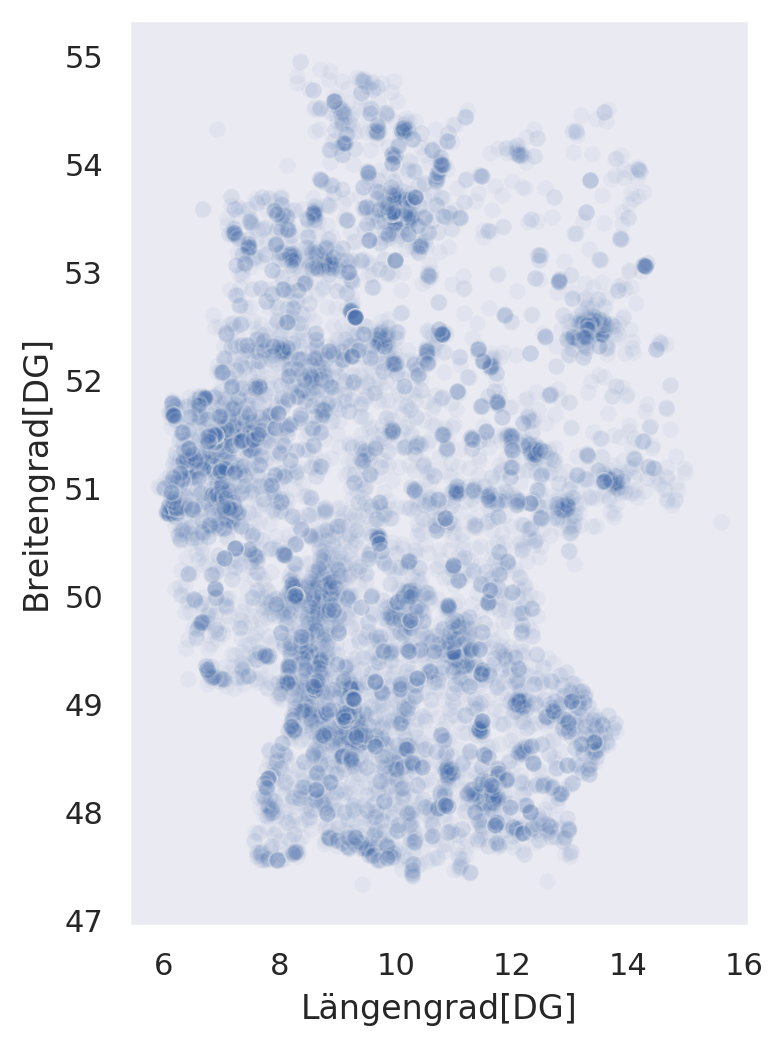

In [120]:
fig, ax = plt.subplots(figsize = (4,6), dpi=200)
sns.scatterplot(data = data, x = 'Längengrad[DG]', y = 'Breitengrad[DG]', alpha=0.05, marker='o', ax=ax);

#### Code for creating animation of the geographical development of charging infrastructure.